#**Loading the initial datasets**

In [ ]:
import pandas as pd
import numpy as np

# Assuming the datasets are already loaded as:
# online_retail = pd.read_excel('OnlineRetail.xlsx')
# cic_ids = pd.read_csv('CSE-CIC-IDS2018.csv')

# Load the synthesized dataset

# 1. Load the datasets
online_retail = pd.read_excel('OnlineRetail.xlsx')
cic_ids = pd.read_csv('CSE-CIC-IDS2018.csv')
synthesized_dataset = pd.read_csv('synthesized_dataset.csv')

# **Print columns for the attack CSV File**

In [ ]:
print(cic_ids.columns)


Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

#**Use the dataset and merge it and also classify the attacks**

    'BENIGN': 0,
    'DDoS': 1,
    'Malware': 2,
    'Phishing': 3,
    'Man-in-the-Middle': 4,
    'SQL Injection': 5

In [ ]:

# Extract selected features for PCA from the pre-loaded datasets
pca_features_ids = cic_ids[[' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets',
                            ' Fwd Packet Length Max', ' Fwd Packet Length Min', 'Bwd Packet Length Max', ' Bwd Packet Length Min']]
pca_features_retail = online_retail[['Quantity', 'UnitPrice']]


# Create a synthesized dataset by combining selected PCA features from both datasets
final_dataset = pd.concat([pca_features_ids, pca_features_retail], axis=1)

# Perform the other transformations as in the previous code
# Load the synthesized dataset


# Create a date range and repeat it to match the length of the dataset
start_date = pd.to_datetime('2017-01-01')
end_date = pd.to_datetime('2022-12-31')
dates = pd.date_range(start_date, end_date).tolist()

# Repeat the date range until we have enough dates
while len(dates) < len(synthesized_dataset):
    dates.extend(pd.date_range(start_date, end_date).tolist())

# Slice the repeated dates to match the exact length of the dataset
dates = dates[:len(synthesized_dataset)]

synthesized_dataset['Date'] = dates
synthesized_dataset['InvoiceDate'] = dates

# Randomizing attack types
attacks = ['BENIGN', 'DDoS', 'Malware', 'Phishing', 'Man-in-the-Middle', 'SQL Injection']
synthesized_dataset['under_attack'] = np.random.choice(attacks, len(synthesized_dataset))

# Assigning return status based on attack type
benign_options = ['not returned', 'returned due to defect', 'returned due to delay']

def assign_return_status(attack):
    if attack == 'BENIGN':
        return np.random.choice(benign_options)
    else:
        return 'return due to possible attack'

synthesized_dataset['return_status'] = synthesized_dataset['under_attack'].apply(assign_return_status)

# Map attack types to numbers
attack_mapping = {
    'BENIGN': 0,
    'DDoS': 1,
    'Malware': 2,
    'Phishing': 3,
    'Man-in-the-Middle': 4,
    'SQL Injection': 5
}

synthesized_dataset['under_attack'] = synthesized_dataset['under_attack'].map(attack_mapping).astype(int)

# Concatenate with the PCA features
final_dataset = pd.concat([synthesized_dataset, pca_features_ids, pca_features_retail], axis=1)

# Save the updated dataset
final_dataset.to_csv('updated_synthesized3_dataset.csv', index=False)


#**Check for the features of the systhesized dataset**

In [ ]:

final_dataset = pd.read_csv('updated_synthesized3_dataset.csv', low_memory=False)
print(final_dataset.columns)


Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Date', 'under_attack',
       'return_status', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', 'Quantity.1', 'UnitPrice.1'],
      dtype='object')


#**Data Cleaning**

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Loading your dataset
final_dataset = pd.read_csv('updated_synthesized3_dataset.csv', low_memory=False)

# Corrected column names
columns_to_clean = [' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets',
                    ' Fwd Packet Length Max', ' Fwd Packet Length Min', 'Bwd Packet Length Max',
                    ' Bwd Packet Length Min', 'Quantity', 'UnitPrice']

# Check for NaN values
nan_values = final_dataset[columns_to_clean].isnull().sum()
print("NaN values per column:\n", nan_values)

# Handling Missing Values: Removing rows with missing values for simplicity
final_dataset_cleaned = final_dataset.dropna(subset=columns_to_clean)

# Removing Outliers using IQR
Q1 = final_dataset_cleaned[columns_to_clean].quantile(0.25)
Q3 = final_dataset_cleaned[columns_to_clean].quantile(0.75)
IQR = Q3 - Q1

final_dataset_cleaned = final_dataset_cleaned[~((final_dataset_cleaned[columns_to_clean] < (Q1 - 1.5 * IQR)) |
                                (final_dataset_cleaned[columns_to_clean] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Standardization
scaler = StandardScaler()
final_dataset_cleaned[columns_to_clean] = scaler.fit_transform(final_dataset_cleaned[columns_to_clean])

# Save the cleaned dataset
final_dataset_cleaned.to_csv('cleaned_dataset.csv', index=False)


NaN values per column:
  Flow Duration             350876
 Total Fwd Packets         350876
 Total Backward Packets    350876
 Fwd Packet Length Max     350876
 Fwd Packet Length Min     350876
Bwd Packet Length Max      350876
 Bwd Packet Length Min     350876
Quantity                   472908
UnitPrice                  472908
dtype: int64


#**Scan the cleaned Dataset**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. Load the cleaned dataset
cleaned_dataset = pd.read_csv('cleaned_dataset.csv')

#**Now use the cleaned dataset and do Principal Component analysis to give the Princpial components and do a correlation matrix so that we can merge vales with much corelation**

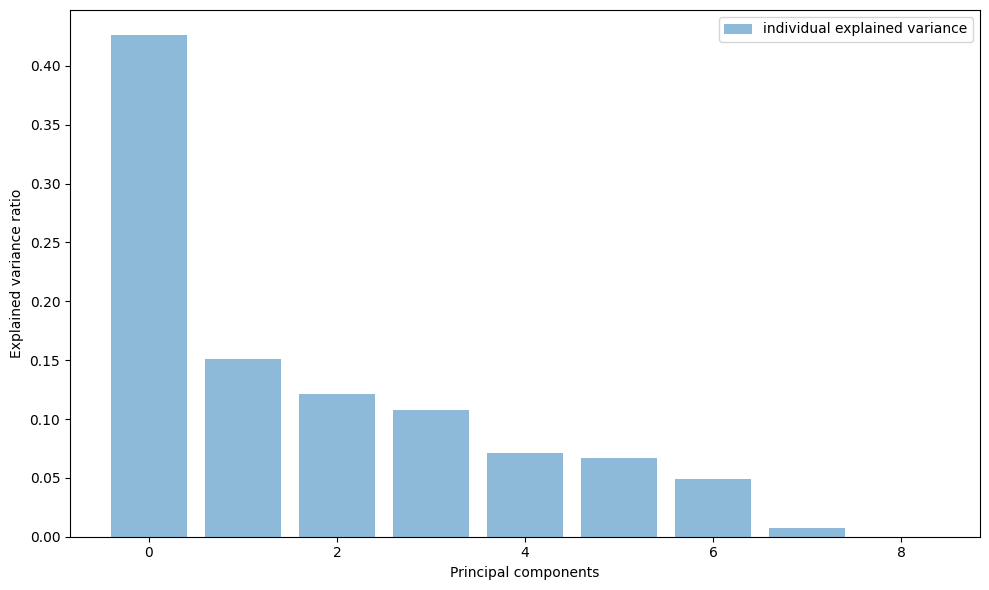

Correlation matrix of original features:
                           Flow Duration   Total Fwd Packets  \
 Flow Duration                 1.000000            0.065121   
 Total Fwd Packets             0.065121            1.000000   
 Total Backward Packets        0.042479            0.154083   
 Fwd Packet Length Max         0.088756            0.016568   
 Fwd Packet Length Min         0.097051           -0.107725   
Bwd Packet Length Max          0.149796            0.000964   
 Bwd Packet Length Min         0.139291            0.000633   
Quantity                      -0.011533           -0.001950   
UnitPrice                      0.006758            0.009100   

                          Total Backward Packets   Fwd Packet Length Max  \
 Flow Duration                          0.042479                0.088756   
 Total Fwd Packets                      0.154083                0.016568   
 Total Backward Packets                 1.000000                0.414634   
 Fwd Packet Length Max 

<Figure size 1200x900 with 0 Axes>

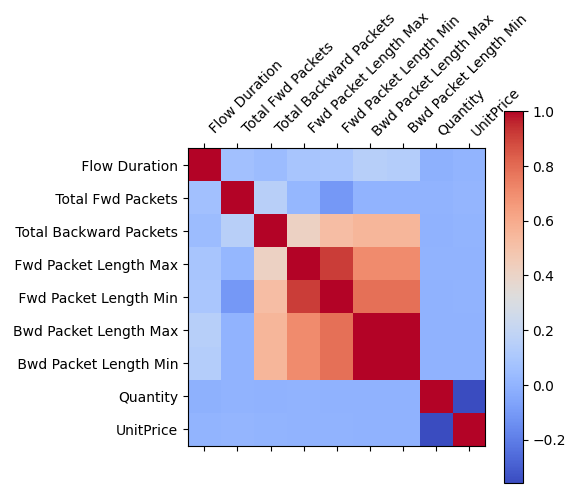

In [ ]:

# Extract only the relevant features for PCA
features = [' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets',
            ' Fwd Packet Length Max', ' Fwd Packet Length Min', 'Bwd Packet Length Max',
            ' Bwd Packet Length Min', 'Quantity', 'UnitPrice']

X = cleaned_dataset[features]

# 2. Perform PCA
pca = PCA(n_components=len(features))
principalComponents = pca.fit_transform(X)

# Create a DataFrame for the principal components
pc_df = pd.DataFrame(data=principalComponents, columns=[f'Principal Component {i+1}' for i in range(len(features))])

# 3. Visualize the explained variance for each principal component
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.bar(range(len(features)), explained_variance, alpha=0.5, align='center', label='individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# 4. Check the correlation among original features
correlation_matrix = X.corr()
print("Correlation matrix of original features:\n", correlation_matrix)

# You might also want to visualize this correlation matrix for a better understanding
plt.figure(figsize=(12, 9))
cax = plt.matshow(correlation_matrix, cmap='coolwarm')
plt.colorbar(cax)
plt.xticks(np.arange(len(features)), features, rotation=45, ha='left')
plt.yticks(np.arange(len(features)), features)
plt.show()


#**Convert it into new dataset where corelated variables are converted**

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load the cleaned dataset
df = pd.read_csv('cleaned_dataset.csv')

# 1. Apply PCA:
# Before applying PCA, ensure that the data is standardized
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.select_dtypes(include=['float64', 'int64']))  # assuming you want to scale only numeric columns

# Apply PCA
pca = PCA()
principal_components = pca.fit_transform(scaled_data)

# Determine the number of principal components that explain 90-95% of the variance
explained_variance = pca.explained_variance_ratio_.cumsum()
n_components = len(explained_variance[explained_variance <= 0.95])

# Retain only the required principal components
df_pca = pd.DataFrame(principal_components[:, :n_components], columns=[f'PC{i}' for i in range(1, n_components+1)])

# 2. Handling Correlated Features:
# If you identified correlated features, consider dropping or combining them
# Example: Dropping one of the correlated features
# df.drop('correlated_feature_name', axis=1, inplace=True)

# 3. Check for Duplicate or Redundant Columns:
# Based on your provided snippet, 'Quantity.1' and 'UnitPrice.1' seem redundant.
# Drop them if they are indeed duplicates.
df.drop(['Quantity.1', 'UnitPrice.1'], axis=1, inplace=True)

# Combine the PCA-transformed data with the non-numeric columns
df_non_numeric = df.select_dtypes(exclude=['float64', 'int64'])
df_combined = pd.concat([df_non_numeric, df_pca], axis=1)

# Save the processed dataset
df_combined.to_csv('processed_dataset.csv', index=False)


#**Check for columns in the processed dataset**

In [ ]:
print(df.columns)

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Date', 'under_attack',
       'return_status', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', 'Quantity.1', 'UnitPrice.1'],
      dtype='object')


In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load the cleaned dataset
df = pd.read_csv('cleaned_dataset.csv')

# Exclude 'underattack' from PCA
features_to_scale = df.select_dtypes(include=['float64', 'int64']).drop(columns=['underattack'], errors='ignore')

# 1. Apply PCA:
# Before applying PCA, ensure that the data is standardized
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features_to_scale)

# Apply PCA
pca = PCA()
principal_components = pca.fit_transform(scaled_data)

# Determine the number of principal components that explain 90-95% of the variance
explained_variance = pca.explained_variance_ratio_.cumsum()
n_components = len(explained_variance[explained_variance <= 0.95])

# Retain only the required principal components
df_pca = pd.DataFrame(principal_components[:, :n_components], columns=[f'PC{i}' for i in range(1, n_components+1)])

# 2. Handling Correlated Features:
# If you identified correlated features, consider dropping or combining them
# Example: Dropping one of the correlated features
# df.drop('correlated_feature_name', axis=1, inplace=True)

# 3. Check for Duplicate or Redundant Columns:
# Based on your provided snippet, 'Quantity.1' and 'UnitPrice.1' seem redundant.
# Drop them if they are indeed duplicates. Note: This is based on a previous example,
# so you should ensure these columns exist before dropping them.
if 'Quantity.1' in df.columns and 'UnitPrice.1' in df.columns:
    df.drop(['Quantity.1', 'UnitPrice.1'], axis=1, inplace=True)

# Combine the PCA-transformed data with the non-numeric columns
df_non_numeric = df.select_dtypes(exclude=['float64', 'int64'])
df_combined = pd.concat([df_non_numeric, df_pca], axis=1)

# Save the processed dataset
df_combined.to_csv('processed1_dataset.csv', index=False)


#**Remove th excess features and clean the dataset some more**

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load the cleaned dataset
df = pd.read_csv('cleaned_dataset.csv')

# If the 'under_attack' column exists, preserve it; else create a placeholder
if 'under_attack' in df.columns:
    under_attack_column = df['under_attack'].copy()
else:
    print("Warning: 'under_attack' column not found in the dataset!")
    under_attack_column = None

# Exclude 'under_attack' from PCA if it exists
features_to_scale = df.select_dtypes(include=['float64', 'int64'])
if 'under_attack' in features_to_scale.columns:
    features_to_scale.drop(columns=['under_attack'], inplace=True, errors='ignore')

# 1. Apply PCA:
# Before applying PCA, ensure that the data is standardized
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features_to_scale)

# Apply PCA
pca = PCA()
principal_components = pca.fit_transform(scaled_data)

# Determine the number of principal components that explain 90-95% of the variance
explained_variance = pca.explained_variance_ratio_.cumsum()
n_components = len(explained_variance[explained_variance <= 0.95])

# Retain only the required principal components
df_pca = pd.DataFrame(principal_components[:, :n_components], columns=[f'PC{i}' for i in range(1, n_components+1)])

# 2. Handling Correlated Features:
# If you identified correlated features, consider dropping or combining them
# Example: Dropping one of the correlated features
# df.drop('correlated_feature_name', axis=1, inplace=True)

# 3. Check for Duplicate or Redundant Columns:
# Based on your provided snippet, 'Quantity.1' and 'UnitPrice.1' seem redundant.
# Drop them if they are indeed duplicates. Note: This is based on a previous example,
# so you should ensure these columns exist before dropping them.
if 'Quantity.1' in df.columns and 'UnitPrice.1' in df.columns:
    df.drop(['Quantity.1', 'UnitPrice.1'], axis=1, inplace=True)

# Combine the PCA-transformed data with the non-numeric columns. Add 'under_attack' if it exists.
df_non_numeric = df.select_dtypes(exclude=['float64', 'int64'])
if under_attack_column is not None:
    df_combined = pd.concat([df_non_numeric, df_pca, under_attack_column], axis=1)
else:
    df_combined = pd.concat([df_non_numeric, df_pca], axis=1)

# Save the processed dataset
df_combined.to_csv('processed_dataset2.csv', index=False)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Load the processed dataset
df = pd.read_csv('processed_dataset2.csv')

# Encode the 'under_attack' column
label_encoder = LabelEncoder()
df['under_attack'] = label_encoder.fit_transform(df['under_attack'])

# One-hot encode categorical columns
df = pd.get_dummies(df, drop_first=True)  # drop_first helps in avoiding multicollinearity

# Split the data into training and testing sets
X = df.drop('under_attack', axis=1)
y = df['under_attack']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 7.25526030267272


In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")


R-squared: -1.4940244780659606


In [ ]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")


Mean Absolute Error: 2.1213146265313867


In [ ]:
import numpy as np
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse}")


Root Mean Squared Error: 2.693559040131239


In [ ]:
from sklearn.metrics import explained_variance_score
evs = explained_variance_score(y_test, y_pred)
print(f"Explained Variance Score: {evs}")


Explained Variance Score: -1.4938469912016106


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Decision Stump
stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)
y_pred_stump = stump.predict(X_test)

# Evaluate model performance
accuracy_stump = accuracy_score(y_test, y_pred_stump)
print(f"Decision Stump Accuracy: {accuracy_stump}")
print(classification_report(y_test, y_pred_stump))


Decision Stump Accuracy: 0.33076493250595534
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5626
           1       0.00      0.00      0.00      5725
           2       0.00      0.00      0.00      5608
           3       0.00      0.00      0.00      5681
           4       0.00      0.00      0.00      5742
           5       0.20      1.00      0.33      5621

    accuracy                           0.33     34003
   macro avg       0.20      0.33      0.22     34003
weighted avg       0.20      0.33      0.22     34003



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Load the processed dataset
df = pd.read_csv('processed_dataset2.csv')

# Check for columns with non-numeric data and convert them
for column in df.columns:
    if df[column].dtype == 'object':
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])

# Split the data into training and testing sets using only 10% of the data
X = df.drop('under_attack', axis=1)
y = df['under_attack']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.98, random_state=42)  # using only 10% as training

# SVM
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# Evaluate model performance
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {accuracy_svm}")
print(classification_report(y_test, y_pred_svm))


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Load the processed dataset
df = pd.read_csv('processed_dataset2.csv')

# Check for columns with non-numeric data and convert them
for column in df.columns:
    if df[column].dtype == 'object':
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])

# Split the data into training and testing sets using only 10% of the data
X = df.drop('under_attack', axis=1)
y = df['under_attack']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, random_state=42)  # using only 10% as training

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

# GBC model
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)

# Predictions
y_pred_gbc = gbc.predict(X_test)

# Metrics
print("Gradient Boosting Classifier Report:")
print(classification_report(y_test, y_pred_gbc))


Gradient Boosting Classifier Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5948
         1.0       0.21      0.19      0.20      6029
         2.0       0.20      0.22      0.21      5938
         3.0       0.20      0.17      0.18      5964
         4.0       0.21      0.24      0.23      6050
         5.0       0.20      0.18      0.19      5963

    accuracy                           0.33     35892
   macro avg       0.33      0.33      0.33     35892
weighted avg       0.33      0.33      0.33     35892



In [ ]:
import xgboost as xgb

# XGBoost model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Metrics
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))


XGBoost Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5948
         1.0       0.21      0.20      0.20      6029
         2.0       0.20      0.21      0.20      5938
         3.0       0.20      0.18      0.19      5964
         4.0       0.20      0.22      0.21      6050
         5.0       0.21      0.20      0.20      5963

    accuracy                           0.33     35892
   macro avg       0.33      0.33      0.33     35892
weighted avg       0.33      0.33      0.33     35892



In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)

# Metrics
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5948
         1.0       0.21      0.21      0.21      6029
         2.0       0.20      0.23      0.21      5938
         3.0       0.20      0.18      0.19      5964
         4.0       0.20      0.22      0.21      6050
         5.0       0.20      0.18      0.19      5963

    accuracy                           0.34     35892
   macro avg       0.34      0.34      0.34     35892
weighted avg       0.34      0.34      0.34     35892

